
# Quantization aware training in Keras

### Librerias

In [6]:
!pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

import tensorflow_model_optimization as tfmot

from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [8]:
print(tfmot.__version__)


0.7.2


### Carga datos

In [9]:
(x_train, _), (x_test, _) = mnist.load_data()

# DATOS
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Creación de modelo

In [10]:
# dimension de dominio intermedio
encoding_dim = 32  

encoder_input = Input(shape=(784,), name="original_img")
# ENCODER
encoded = Dense(256, activation='relu')(encoder_input)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoder_out = Dense(encoding_dim, activation='relu')(encoded)

# DECODER
encoded_input = Input(shape=(encoding_dim,))
decoded = Dense(64, activation='relu')(encoded_input)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoder_output = Dense(784, activation='sigmoid')(decoded)

# Modelo para el encoder
encoder = Model(encoder_input, encoder_out, name="encoder")

# Modelo del decoder
decoder = Model(encoded_input, decoder_output, name="decoder")

In [11]:
quantize_model = tfmot.quantization.keras.quantize_model

q_encoder_model = quantize_model(encoder)
q_decoder_model = quantize_model(decoder)

# AUTOENCODER
autoencoder_input = Input(shape=(784,), name="img")
encoded_img = q_encoder_model(autoencoder_input)
decoded_img = q_decoder_model(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img, name="autoencoder")

autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss='mse')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 32)                244215    
                                                                 
 decoder (Functional)        (None, 784)               244967    
                                                                 
Total params: 489,182
Trainable params: 489,136
Non-trainable params: 46
_________________________________________________________________


En caso de autoencoder requiere quantizar encoder y decoder de forma separada

### Entrenamiento cuantizado

### Train

In [12]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=50),
                # tf.keras.callbacks.ModelCheckpoint(filepath='./quant_models/quant_aware_dense.h5'),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, verbose=1, min_delta=1e-8, mode='min')]

In [13]:
autoencoder.fit(x_train, x_train,
                epochs=1000,
                #batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks = my_callbacks)

Epoch 1/1000
1875/1875 [==============================] - 23s 9ms/step - loss: 0.0394 - val_loss: 0.0299 - lr: 0.0010
Epoch 2/1000
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0283 - val_loss: 0.0276 - lr: 0.0010
Epoch 3/1000
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0294 - val_loss: 0.0291 - lr: 0.0010
Epoch 4/1000
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0332 - val_loss: 0.0368 - lr: 0.0010
Epoch 5/1000
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0333 - val_loss: 0.0272 - lr: 0.0010
Epoch 6/1000
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0258 - val_loss: 0.0245 - lr: 0.0010
Epoch 7/1000
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0231 - val_loss: 0.0220 - lr: 0.0010
Epoch 8/1000
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0217 - val_loss: 0.0209 - lr: 0.0010
Epoch 9/1000
1875/1875 [==============================] 

In [14]:
# autoencoder.load_weights('./quant_models/quant_aware_dense.h5')

### Convert

In [19]:
tflite_model_path = "./quant_aware_dense.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open(tflite_model_path, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgahurmn3/assets


INFO:tensorflow:Assets written to: /tmp/tmpgahurmn3/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


500280

### Charge and predict

In [ ]:
batch = 1

tflite_interpreter = tf.lite.Interpreter(model_path = tflite_model_path)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (batch, 784))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (batch, 784))
tflite_interpreter.allocate_tensors()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])


In [ ]:
def iterate(array, batch):
    inf = 0
    sup = batch
    while sup < len(array)+batch:
        res = array[inf:sup, :]
        yield res
        inf += batch
        sup += batch

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path = tflite_model_path)

In [ ]:
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

t1 = time.time()
iterator_test = iterate(x_test, 1)
results = []

#while True:
#    try:    
tflite_interpreter.set_tensor(input_details, next(iterator_test))

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details)
results.append(tflite_model_predictions)
#    except:
#        break
t2 = time.time()
print(f"Execute time: {round(t2 - t1, 2)} segs")

### Predict

In [15]:
quant_decoded = autoencoder.predict(x_test)

### Test

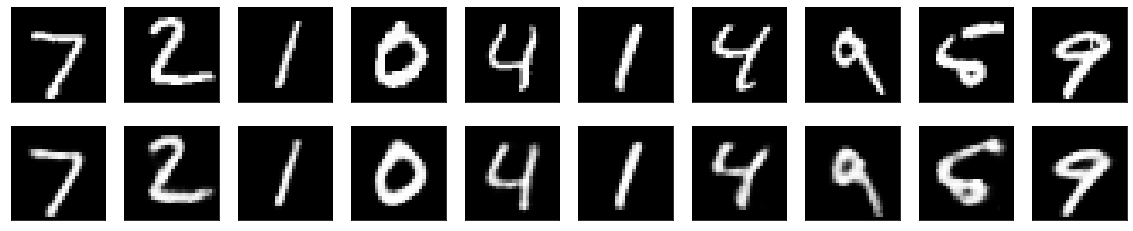

In [16]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(quant_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()